# Running on a cluster

We'll use a Dask cluster in the cloud—in this case, using [Coiled](https://coiled.io/)—to use many machines to process the data in parallel. We can also run in the data center where the data is stored for better performance.

If you use Coiled (which is both easy to use, and currently free!), you can set `software="gjoseph92/stackstac"` to get a software environment where the latest version of `stackstac` is already installed.

In [1]:
import coiled
import distributed

cluster = coiled.Cluster(
    name="stackstac",
    software="gjoseph92/stackstac",
    backend_options={"region": "us-west-2"},
    n_workers=8,
    protocol="wss",  # remove this line when not running on Binder
)
client = distributed.Client(cluster)
client

Output()

<Client: 'tls://10.6.8.224:8786' processes=2 threads=4, memory=7.55 GiB>

In [2]:
import stackstac
import pystac_client
from rasterio.enums import Resampling

### Search for a full year of Sentinel-2 data over Santa Fe, New Mexico.

We'll look at 2019-2020.

In [3]:
%%time
items = pystac_client.Client.open(
    "https://earth-search.aws.element84.com/v0"
).search(
    intersects=dict(type="Point", coordinates=[-106, 35.7]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2019-01-01/2020-01-01",
    limit=10_000,
).get_all_items()
len(items)

CPU times: user 205 ms, sys: 25 ms, total: 230 ms
Wall time: 1.94 s


294

### Set a coarser resolution to speed up the computation

We'll have `stackstac` retrieve the data at 100m resolution, instead of its native 10m.
Since the data is stored in [Cloud-Optimized GeoTIFFs](https://www.cogeo.org/) with internal overviews, fetching lower-resolution data is very efficient and requires processing an order of magnitude less data.

(Internally, `stackstac` is just telling rasterio/GDAL to build a VRT at this resolution. GDAL then automatically figures out which overview level to fetch data from.)

We also set `bounds_latlon` to just the area we want to look at (additionally, this drops any items that don't intersect that bounding box), and set the resampling method to bilinear to produce a nicer-looking image.

In [4]:
%%time
stack = stackstac.stack(
    items,
    resolution=100,
    bounds_latlon=(-106.2, 35.6, -105.6, 36),
    resampling=Resampling.bilinear
)

CPU times: user 144 ms, sys: 6.43 ms, total: 151 ms
Wall time: 149 ms


In [5]:
stack

<xarray.DataArray 'stackstac-d455fb5bfb0225280aa919c606ad995b' (time: 294,
                                                                band: 17,
                                                                y: 450, x: 547)>
dask.array<fetch_raster_window, shape=(294, 17, 450, 547), dtype=float64, chunksize=(1, 1, 450, 547), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                        (time) datetime64[ns] 2019-01-02T18:04:01 ......
    id                          (time) <U24 'S2A_13SDV_20190102_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'B11' ... 'visual' 'SCL'
  * x                           (x) float64 3.913e+05 3.914e+05 ... 4.459e+05
  * y                           (y) float64 3.985e+06 3.985e+06 ... 3.94e+06
    sentinel:utm_zone           int64 13
    ...                          ...
    sentinel:data_coverage      (time) object 33.92 100 100 ... 100 100 42.39
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None 'swir16' ... None None
    center_wavelength           (band) object None 1.6137 0.4439 ... None None
    full_width_half_max         (band) object None 0.143 0.027 ... None None
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(391300, 3939700, 446000, 3984...
    crs:         epsg:32613
    transform:   | 100.00, 0.00, 391300.00|\n| 0.00,-100.00, 3984700.00|\n| 0...
    resolution:  100

For comparison, this is how much data we'd be processing if we'd used full 10m resolution:

In [6]:
import dask
dask.utils.format_bytes(stackstac.stack(items).nbytes)

'8.38 TiB'

### Prepare monthly RGB composites

Now, use standard xarray methods to select out the red, green, and blue bands, then make monthly median composites.

In [7]:
rgb = stack.sel(band=["B04", "B03", "B02"])
monthly_rgb = rgb.resample(time="MS").median(dim="time")
monthly_rgb

<xarray.DataArray 'stackstac-d455fb5bfb0225280aa919c606ad995b' (time: 12,
                                                                band: 3,
                                                                y: 450, x: 547)>
dask.array<stack, shape=(12, 3, 450, 547), dtype=float64, chunksize=(1, 2, 450, 547), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time                    (time) datetime64[ns] 2019-01-01 ... 2019-12-01
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 3.913e+05 3.914e+05 ... 4.459e+05
  * y                       (y) float64 3.985e+06 3.985e+06 ... 3.94e+06
    sentinel:utm_zone       int64 13
    proj:epsg               int64 32613
    ...                      ...
    constellation           <U10 'sentinel-2'
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int64 32613

### Compute in parallel on the cluster

In [8]:
client.wait_for_workers(8)

In [9]:
%time rgb_ = monthly_rgb.compute()

CPU times: user 1.95 s, sys: 466 ms, total: 2.42 s
Wall time: 2min 33s


Using 8 Coiled workers (2 CPU, 8 GiB memory each), we processed the ~10 GB of data into median composites in a couple minutes.

Go to the dashboard at https://cloud.coiled.io to watch the computation in progress.

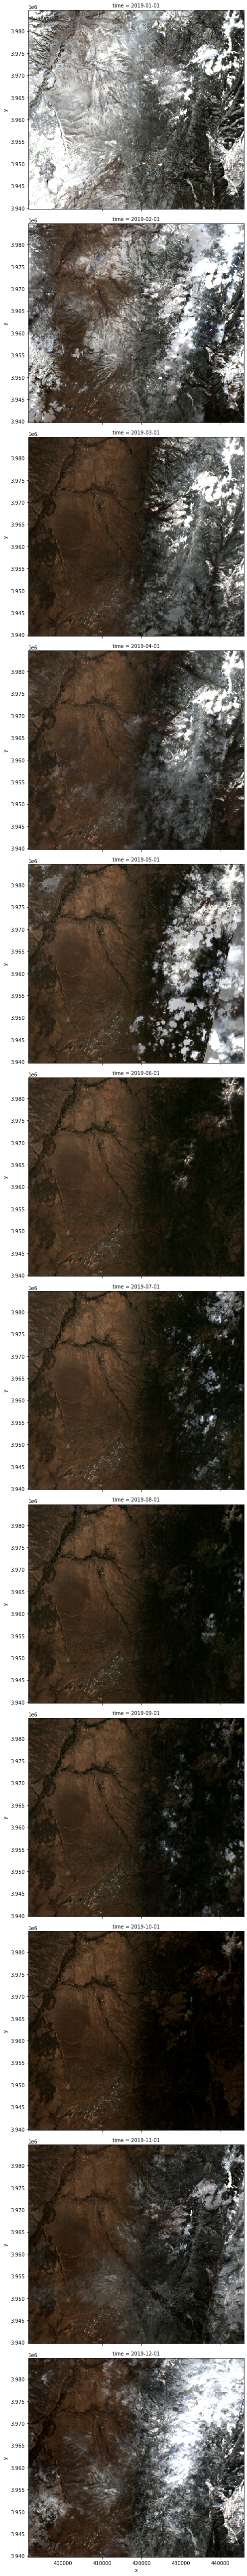

In [10]:
rgb_.plot.imshow(row="time", rgb="band", robust=True, size=6);

According to the Coiled dashboard, this cost about 74 cents. Was this picture worth 74 cents to you?